In [6]:
%pip install -q matplotlib networkx pandas torchinfo
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import functions
import json
import matplotlib.pyplot as plt
import torch

from torchinfo import summary

In [8]:
path = "/notebooks/runs/resgcn_adj_type_downstream/2023-04-22_19-46-43.run"
chkpt = torch.load(path[11:])
print(json.dumps(chkpt["hparams"], indent=4))

{
    "data": {
        "window_size": 24,
        "stride_length": 1,
        "lead_time": 1,
        "normalized": true
    },
    "model": {
        "architecture": "ResGCN",
        "num_layers": 20,
        "hidden_channels": 64,
        "param_sharing": false,
        "graff_step_size": 1,
        "edge_orientation": "downstream",
        "adjacency_type": "binary"
    },
    "training": {
        "num_epochs": 20,
        "batch_size": 16,
        "learning_rate": 0.0001,
        "weight_decay": 0,
        "random_seed": 42,
        "holdout_size": 0.25
    }
}


In [9]:
model, dataset = functions.load_model_and_dataset(chkpt)
summary(model, depth=2)

Loading dataset into memory...


100%|██████████| 375/375 [00:29<00:00, 12.74it/s]


Layer (type:depth-idx)                   Param #
ResGCN                                   --
├─Linear: 1-1                            1,600
├─Linear: 1-2                            65
├─ModuleList: 1-3                        --
│    └─GCNConv: 2-1                      4,160
│    └─GCNConv: 2-2                      4,160
│    └─GCNConv: 2-3                      4,160
│    └─GCNConv: 2-4                      4,160
│    └─GCNConv: 2-5                      4,160
│    └─GCNConv: 2-6                      4,160
│    └─GCNConv: 2-7                      4,160
│    └─GCNConv: 2-8                      4,160
│    └─GCNConv: 2-9                      4,160
│    └─GCNConv: 2-10                     4,160
│    └─GCNConv: 2-11                     4,160
│    └─GCNConv: 2-12                     4,160
│    └─GCNConv: 2-13                     4,160
│    └─GCNConv: 2-14                     4,160
│    └─GCNConv: 2-15                     4,160
│    └─GCNConv: 2-16                     4,160
│    └─GCNConv: 2-17

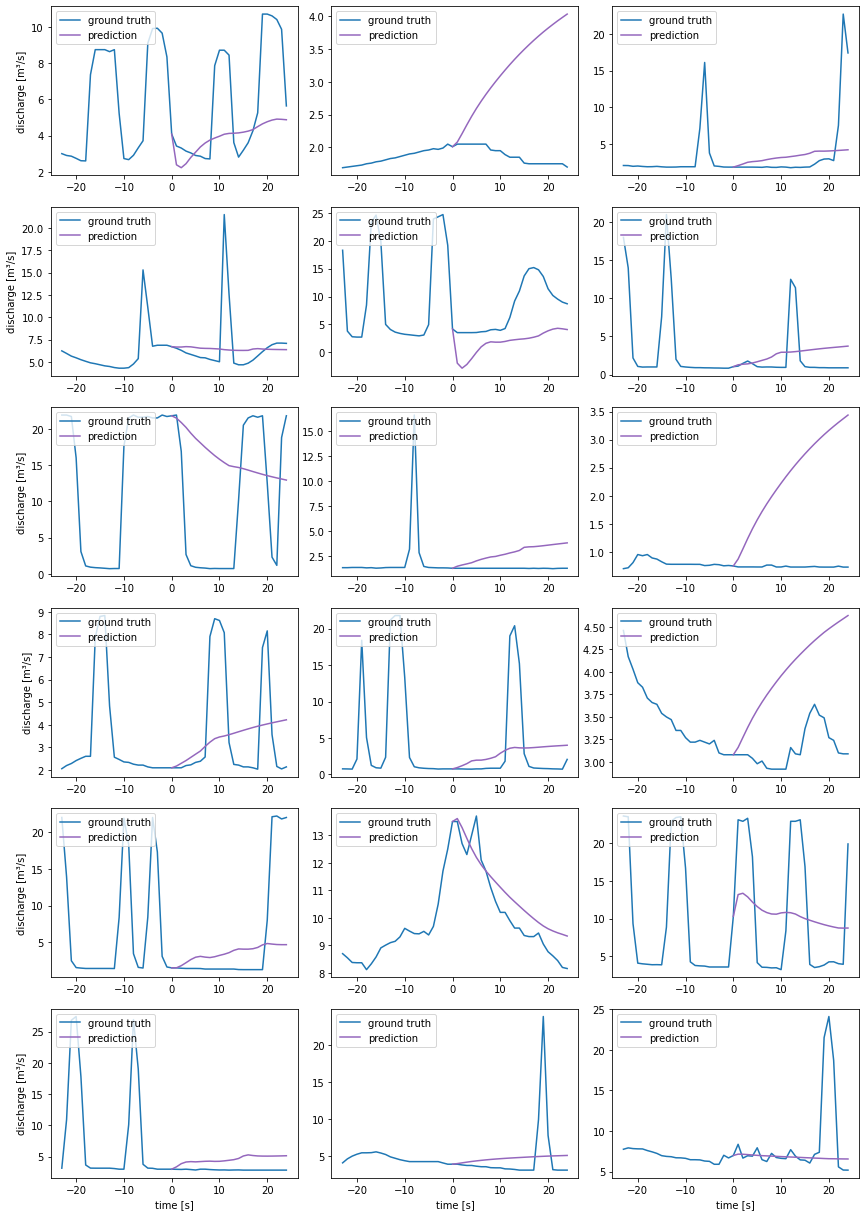

In [10]:
window_size = chkpt["hparams"]["data"]["window_size"]
iterations = 24
time = range(-window_size + 1, iterations + 1)
gauge = dataset.gauges.index(85)  # outlier gauge 85
functions.ensure_reproducibility(0)
start_indices = torch.randperm(len(dataset) - iterations + 1)

plt.figure(figsize=(12, 17))
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for (k, start) in enumerate(start_indices[:18]):
    pred = functions.rolling_forecast(model, dataset[start], iterations)
    truth = torch.cat([dataset[start].x] + [dataset[start + i].y for i in range(iterations)], dim=1)
    plt.subplot(6, 3, k + 1)
    plt.plot(time, dataset.denormalize(truth)[gauge], label="ground truth", color=colors[0])
    plt.plot(time[(window_size - 1):], dataset.denormalize(pred)[gauge, (window_size - 1):], label="prediction", color=colors[4])
    if k // 3 == 5:
        plt.xlabel("time [s]")
    if k % 3 == 0:
        plt.ylabel("discharge [m³/s]")
    plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig("recurrent_forecasting.pdf")
plt.show()